In [15]:
import torch
import math
import matplotlib.pyplot as plt

In [16]:
# autograd globally off
torch.set_grad_enabled(False)

### Layer Modules

In [7]:
class Module(object):
    """
    Base class to be inherited by other modules
    """
    def __init__(self):
        self.parameters = []

    def forward(self, *input):
        raise NotImplementedError

    def backward(self, *gradwrtoutput):
        raise NotImplementedError

    def param(self):
        return self.parameters

In [8]:
class Linear(Module):
    """
    Implements linear layer, with or without bias
    Parameters: number of input and output features
    """
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        # using pytorch default weight initialization
        init_range = 1. / math.sqrt(in_features)
        self.weights = torch.Tensor(in_features, out_features).uniform_(-init_range, init_range)
        self.grad_w = torch.zeros((in_features, out_features))
        self.parameters = [(self.weights, self.grad_w)]
        if bias:
            # default bias initialization
            self.bias = torch.Tensor(out_features).uniform_(-init_range, init_range)
            self.grad_b = torch.zeros(out_features)
            self.parameters.append((self.bias, self.grad_b))
        else:
            self.bias = None

    def forward(self, input_):
        # Returns tensor of size N * out_features
        self.input = input_
        if self.bias is not None:
            return torch.addmm(self.bias, input_, self.weights)
        else:
            return input_.matmul(self.weights)

    def backward(self, grad_output):
        # Returns tensor of size N * in_features, computes gradient wrt the weights
        self.grad_w += self.input.t().matmul(grad_output)
        grad_input = grad_output.matmul(self.weights.t())
        if self.bias is not None:
            self.grad_b += grad_output.sum(dim=0)
        return grad_input

### Activation functions

In [9]:
class ReLU(Module):
    """
    Implements Rectifier Linear Unit activation
    Only positive inputs are back-propagated
    """
    def forward(self, input_):
        self.input = input_
        return torch.relu(input_)

    def backward(self, grad_output):
        return torch.mul((self.input > 0).int(), grad_output)


class Tanh(Module):
    """
    Implements tanh activation
    The derivative of tanh(x) is 1 - tanh(x) ** 2
    """
    def forward(self, input_):
        self.input = input_
        return torch.tanh(input_)

    def backward(self, grad_output):
        return torch.tanh(self.input).pow(2).mul(-1).add(1).mul(grad_output)

### Loss functions

In [10]:
class MSELoss(Module):
    def __init__(self):
        super().__init__()

    # Overloading __call__ method
    # Example:
    # loss = MSELoss()
    # loss(input, target)

    def __call__(self, input_, target):
        return self.forward(input_, target)

    def forward(self, input_, target):
        if input_.size() != target.size():
            raise Exception("Dimensions do not match")
        if target.dim() == 1:
            target = target.view(target.size(0), 1)
        return (input_ - target).pow(2).mean().item()

    def backward(self, input_, target):
        if input_.size() != target.size():
            raise Exception("Dimensions do not match")
        if target.dim() == 1:
            target = target.view(target.size(0), 1)

        return (input_ - target).mul(2).div(target.size(0))

### Concatenate different layers

In [11]:
class Sequential(Module):
    """
    Implements sequential layer to combine multiple modules given in *args
    # Usage example: Sequential(layer1, layer2, layer3)
    """
    def __init__(self, layers):
        self.layers = layers
        self.parameters = []
        for layer in layers:
            self.parameters += layer.parameters

    def __call__(self, input_):
        return self.forward(input_)

    def zero_grad(self):
        for w, dw in self.parameters:
            dw.zero_()

    def forward(self, input_):
        x = input_
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, loss_grad):
        y = loss_grad
        for layer in reversed(self.layers):
            y = layer.backward(y)
        return

In [18]:
def generate_set(num):
#   using pytorch tensor operation
#   return the generated random points and labels
    random_points = torch.rand((num, 2))
    # check if the point is in the circle centered at (0.5,0.5) of radius 1/sqrt(2*math.pi)
    targets=torch.Tensor([int(pow(x[0]-0.5,2)+pow(x[1]-0.5,2)<1/(2*math.pi)) for x in random_points]).view(-1,1)
    return random_points, targets

In [12]:
def train_model(model, train_input, train_target,test_input, test_target, batch_size=25, n_epochs=700, loss=MSELoss(), learning_rate=0.1):
    """
    Train model
    :param model: Sequence instance
    :param train_input: tensor of size [size, 2] with coordinates x,y of the samples
    :param train_target: tensor of size [size,1] with labels of the samples
    :param test_input: tensor of size [size, 2] with coordinates x,y of the samples
    :param test_target: tensor of size [size,1] with labels of the samples
    :param batch_size: (int) size of batch to perform SGD
    :param n_epochs: (int) number of iterations along the whole train set
    :param loss: loss function instance
    :param learning_rate: (float) which is used to perform SGD
    :return: my_loss: (list) values of loss along the epochs
    """
    # train model
    train_loss_history=[]
    train_accuracy=[]
    test_loss_history=[]
    test_accuracy=[]
    
    sample_size = train_input.size(0)
    sgd = SGD(model.parameters, learning_rate)
    for epoch in range(n_epochs):
        cumulative_loss = 0
        for n_start in range(0, sample_size, batch_size):
            # resetting the gradients
            model.zero_grad()
            output = model(train_input[n_start : n_start + batch_size])
            # accumulating the loss over the mini-batches
            cumulative_loss += loss(output, train_target[n_start : n_start + batch_size]) * batch_size
            # calculating the gradient of the loss wrt final outputs
            loss_grad = loss.backward(output, train_target[n_start : n_start + batch_size])
            # propagating it backward
            model.backward(loss_grad)
            # updating the parameters
            sgd.step()
        
        # get the training loss and accuracy
        train_pred=model(train_input) 
        train_loss=loss(train_pred,train_target)
        train_loss_history.append(train_loss)
        train_accuracy_result=compute_accuracy(train_target,train_pred)
        train_accuracy.append(train_accuracy_result)

        # get the testing loss and accuracy
        test_pred=model(test_input)
        test_loss=loss(test_pred,test_target)
        test_loss_history.append(test_loss)
        test_accuracy_result=compute_accuracy(test_target,test_pred)
        test_accuracy.append(test_accuracy_result)
        
        #Printing the results of the current iteration
        print("The average training loss at epoch {} is {}".format(epoch+1,(cumulative_loss / sample_size)),end='\r')
    print("\r")
    print("The test accuracy is ", compute_accuracy(test_target,test_pred))
    #Plotting the train and test loss and accuracy figure

    #Setting-up the plot
    plt.figure(figsize=(15,8))

    ax1 = plt.subplot(1,2,1)

    ax2 = plt.subplot(1,2,2)

    #Drawing and labeling the curves
    ax1.plot(train_loss_history, label="Training Loss")
    ax1.plot(test_loss_history, label="Test Loss")

    #Adding the title and axis labels
    ax1.set_title('Train VS Test Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend()

    #Saving the plot
    ax1.figure.savefig('loss.png')


    #Drawing and labeling the curves
    ax2.plot(train_accuracy, label="Train Accuracy")
    ax2.plot(test_accuracy, label="Test Accuracy")

    #Adding the title and axis labels
    ax2.set_title('Train VS Test Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend()

    #Saving the plot
    ax2.figure.savefig('accuracy.png')


def compute_accuracy(true_target, predicted):
    return (true_target-(predicted>0.5).float()).eq(0).float().mean().item()
    

In [13]:
class SGD:
    def __init__(self, parameters, learning_rate):
        self.parameters = parameters
        self.learning_rate = learning_rate

    def step(self):
        for w, dw in self.parameters:
            w.sub_(dw.mul(self.learning_rate))

The average training loss at epoch 1000 is 0.01619313452611095
The test accuracy is  0.9789999723434448


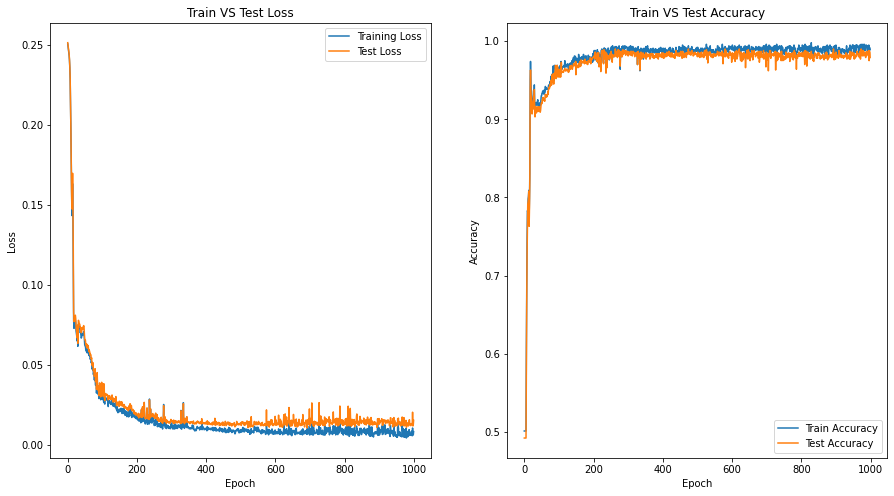

In [14]:
sample_size = 1000

train_input, train_target = generate_set(sample_size)
test_input, test_target = generate_set(sample_size)


layers = [Linear(2, 25), ReLU(), Linear(25, 25), ReLU(), Linear(25, 25), ReLU(), Linear(25, 25), ReLU(), Linear(25, 1)]
model = Sequential(layers)

train_model(model, train_input, train_target,test_input, test_target, batch_size=25, n_epochs=1000, loss=MSELoss(), learning_rate=0.1)
    
# accuracy = []
# for n in range(0,1001,100):
#     train_model(model, train_input, train_target,print_loss=False,n_epochs=n)
#     # print("Train accuracy: %f" % accuracy(train_target, model(train_input)))
#     # print("Test accuracy: %f" % accuracy(test_target, model(test_input)))

#     a = model(train_input)
#     correct = 0

#     for i in range(len(a)):
#         a[i] = 1 if a[i]>0 else 0
#         if (a[i] == train_target[i]):
#             correct += 1
#     accuracy.append(correct/1000)
# accuracy